In [1]:
import numpy as np
from visualize_grid import visualize_grid
# generate data
m,n = (5,5) # grid size

In [2]:
from ShortestPathGrid import ShortestPathGrid
cost = np.arange((m-1)*n + m*(n-1))
np.random.shuffle(cost)
grid = ShortestPathGrid(m, n, cost=cost)

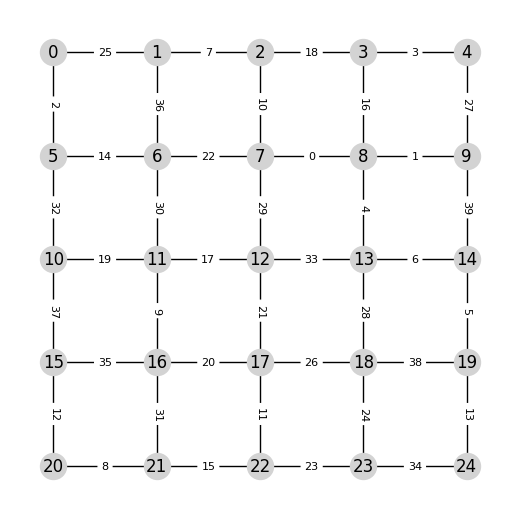

In [3]:
grid.visualize()

In [4]:
# Set source and target of optimization
s = 1 # source node
t = 23 # target node
# Solve the shortest path problem
sol, obj = grid.solve(source=s, target=t)

Optimal objective: 73


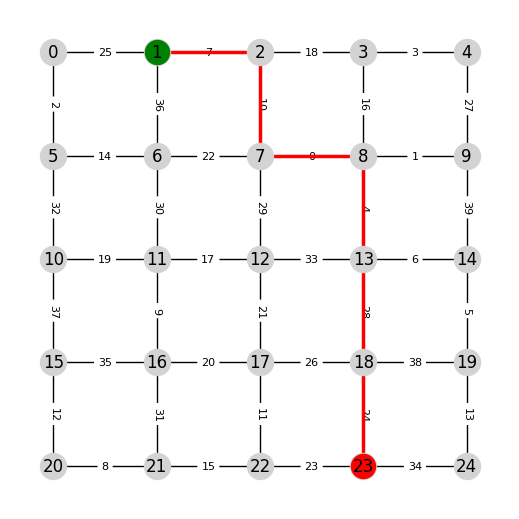

In [5]:
# Visualize the solution
grid.visualize(s = s, t = t, color_edges=sol)
print("Optimal objective:", obj)

In [6]:
import pyepo

# Set parameters for data generation
num_train_data = 1000 # number of training data
num_test_data = 1000 # number of test data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width

# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(num_train_data+num_test_data, num_feat, (m,n), deg=deg, noise_width=e, seed=135)

In [7]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=num_test_data, random_state=42)

In [8]:
from LinearRegression import LinearRegression

# Instantiate linear regression model
model = LinearRegression(num_feat=num_feat, num_edges=grid.get_num_edges())

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# 3. Choose loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [10]:
# Data loading
train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(c_train).float())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

In [11]:
from trainer import Trainer

# # 2) Build your two‐stage network:
# #    e.g. lr = LinearRegression(...); opt = ShortestPath(...)
# #    maybe wrap them in a single nn.Module
# model = MyOptNetPipeline(linear_model=model, opt_model=opt)

# 4) Train
trainer = Trainer(model, optimizer, criterion)
trainer.fit(train_loader, epochs=50)


Epoch 000 | Train Loss: 1.4505
Epoch 005 | Train Loss: 1.0335
Epoch 010 | Train Loss: 0.7537
Epoch 015 | Train Loss: 0.5658
Epoch 020 | Train Loss: 0.4396
Epoch 025 | Train Loss: 0.3547
Epoch 030 | Train Loss: 0.2974
Epoch 035 | Train Loss: 0.2588
Epoch 040 | Train Loss: 0.2328
Epoch 045 | Train Loss: 0.2152


In [41]:
# 4. Training loop
n_epochs = 100
loss_vec = []
for epoch in range(1, n_epochs + 1):
    for i, data in enumerate(train_loader):
        x_train, c_train = data
        # Cuda
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            c_train = c_train.cuda()
            model = model.cuda()
        # Reset gradients
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        c_pred = model(x_train)          # forward pass
        loss = criterion(c_pred, c_train)
        
        # Backward pass
        loss.backward()            # backprop
        optimizer.step()           # update parameters
    
    loss_vec.append(loss.item())
    if epoch % 20 == 0:
        print("Epoch {:2},  Loss: {:9.4f}%".format(epoch+1, loss.item()))

Epoch 21,  Loss:    0.4325%
Epoch 41,  Loss:    0.2304%
Epoch 61,  Loss:    0.1167%
Epoch 81,  Loss:    0.1378%
Epoch 101,  Loss:    0.1686%


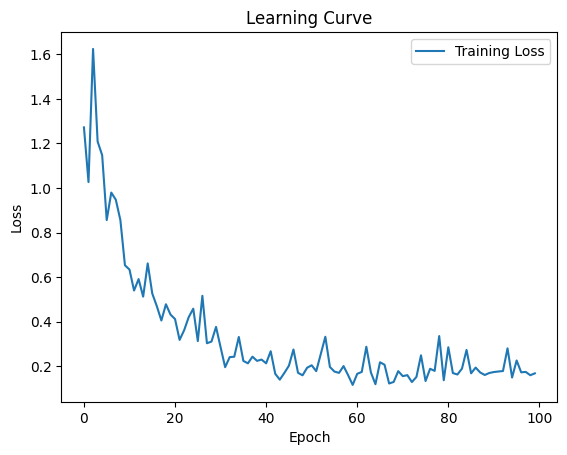

In [42]:
import matplotlib.pyplot as plt

# 6. (Optional) Plot learning curve
plt.plot(loss_vec, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()